# Why Walk When You Can Zipline?

Sam Daitzman and Jocelyn Jimenez

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr'

# import functions from the modsim.py module
from modsim import *

# Introduction
Although Olin is a very small campus, it is sometimes very tedious having to walk through various curved paths and flights of stairs. We noticed that there was great potential of a zip line from Olin’s Academic Center to West Hall. Initially there were multiple issues that arose. For instance, where will the landing spot be? In the case of our model, we believe it is best if the zip line ends on the corner room in West Hall on the second floor because it gives us the fastest access to most dorms in West Hall. If we were to ask “Which floor in the AC allows us to get faster to our destination?” the answer would be obvious, the 4th floor; but if you zipline at too steep an angle, you are likely to get injured. As a result, we decided to take into consideration the safety of the individual in order to make it a more useful model. Our model asks what the fastest safe zip line starting mount-point would be to get from the AC to West Hall as fast as (safely) possible.

In [2]:
# units!
year = UNITS.year
s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
AU = UNITS.astronomical_unit;

In [3]:
x_0 = (0 * m)
y_0 = (0 * m)

vx_0 = 0 * m / s
vy_0 = 0 * m / s

init = State(x=x_0,
             y=y_0,
             vx=vx_0,
             vy=vy_0)

In [4]:
# TODO: make this a params and a make_system()
# def make_system(params):
#     """Make a system object.
    
#     params: Params object with angle, velocity, x, y,
#                diameter, duration, g, mass, rho, and C_d
               
#     returns: System object
#     """
#     unpack(params)
    
#     # convert angle to degrees
#     theta = np.deg2rad(angle)
    
#     # compute x and y components of velocity
#     vx, vy = pol2cart(theta, velocity)
    
#     # make the initial state
#     init = State(x=x, y=y, vx=vx, vy=vy)
    
#     # compute area from diameter
#     area = np.pi * (diameter/2)**2
    
#     return System(params, init=init, area=area)


system = System(init=init,
  G=6.674e-11 * N / kg ** 2 * m ** 2,
  m_sun=1.99e30 * kg,
  m_human=70 * kg,
  grav = Vector(0 * m / s ** 2, -9.81),
  rho = 1.275 * kg / m ** 3, 
  area = 0.7 * m ** 2, 
  cd = 1.2, # UPDATE THIS 
  t_end=100e6 * s,
  z = Vector(100 * m, -25.1)
)

In [5]:
def earth_grav(m, g):
  return g * m

In [6]:
earth_grav(100*kg, system.grav)

<Quantity([   0. -981.], 'kilogram * meter / second ** 2')>

In [7]:
def drag_force(rho, v, area, cd):
  direction= -v.hat()
  drag = (1/2) * rho * v.mag**2 *area * cd
  return direction * drag

In [8]:
drag_force(20 * kg / m ** 3, Vector(3 * m / s, 4), 10 * m ** 2, 0.8)

<Quantity([-1200. -1600.], 'kilogram * meter / second ** 2')>

In [9]:
def effective_force(state, system):
  """Calculates gravitational force for arbitrary objects"""
  x, y, vx, vy = state
  unpack(system)
  
  grav_f = earth_grav(m_human, grav)
  drag_f = drag_force(rho, Vector(vx, vy), area, cd)
  
  net_force = grav_f + drag_f
  
  effective_force = net_force.proj(z.hat())

  return effective_force

In [10]:
def slope_func(state, t, system):
    x, y, vx, vy = state
    
    unpack(system)
    
    # make velocity
    v = Vector(vx, vy)
    
    # calculate force
    force = effective_force(state, system)
    
    # calculate acceleration
    a = force * (1/m_human)
    
    # cast acceleration to modsimvector
    a = Vector(a[0], a[1])
    
    # return velocity and acceleration
    return vx, vy, a.x, a.y
  
vx, vy, ax, ay = slope_func(init, 0, system)
print(vx, vy, ax, ay)

0.0 meter / second 0.0 meter / second 2.3163759958833534 meter / second ** 2 -0.5814103749667217 meter / second ** 2


In [11]:
def event_func(state, t, system):
    x, y, vx, vy = state
    position = Vector(x, y)
    return position.mag - z.mag

In [12]:
event_func(init, 0, system)

<Quantity(-103.10193984596022, 'meter')>

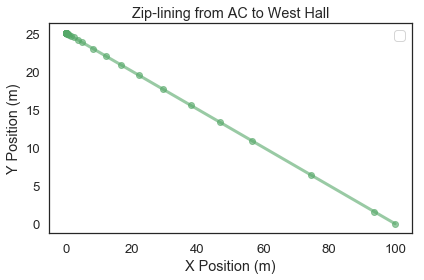

In [13]:
results, details = run_ode_solver(system, slope_func, events=event_func, method='LSODA')
plot(results.x, results.y - z.y.magnitude, 'go-')
decorate(title='Zip-lining from AC to West Hall',
         xlabel='X Position (m)',
         ylabel='Y Position (m)')

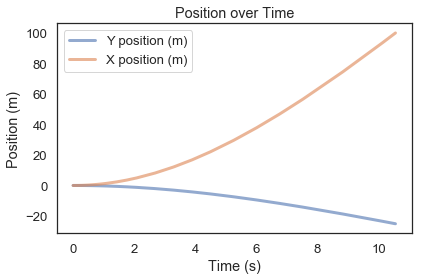

In [14]:
plot(results.y, label='Y position (m)')
plot(results.x, label='X position (m)')
decorate(title='Position over Time',
   xlabel='Time (s)',
   ylabel='Position (m)',
  legend=True)

In [15]:
v_final = Vector(get_last_value(results.vx) * m / s, get_last_value(results.vy))
print(v_final.mag)

15.73897673293782 meter / second


In [16]:
def event_func(state, t, system):
    x, y, vx, vy = state
    position = Vector(x, y)
    return position.mag

In [0]:
results, details = run_ode_solver(system, slope_func, events=event_func, method='RK23')
results.index /= 60 * 60 * 24
# results.r *= (0.000621371 / 1000)
plot(results.y, 'go-')
decorate(title='Earth Orbit',
         xlabel='Time (days)',
         ylabel='Y Position (m)')

NameError: ignored

In [0]:
# Imports
from IPython.display import clear_output
import os
import time

# Install Python libraries
!pip3 install pandas seaborn sympy beautifulsoup4 lxml pint scipy==1.1.0 numpy

# Removes code before re-downloading it
!rm -rf ./ModSimPy
!rm -rf ./modsim.py

# Grabs ModSimPy
!git clone https://github.com/AllenDowney/ModSimPy.git
!cp "ModSimPy/code/modsim.py" .

# Resets kernel to flush outdated libraries (especially SciPy)
clear_output()
print("Configured for ModSimPy. Restarting kernel.")
time.sleep(1)
os._exit(0)

Configured for ModSimPy. Restarting kernel.
